Data Pre-processing¶

This notebook lists the steps of pre-processing the loan data from Lending Club (https://www.kaggle.com/wordsforthewise/lending-club/metadata) before applying it for training.

Import the packages required for the Data pre-processing:

In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas_profiling import ProfileReport

from matplotlib import cm 

In [2]:
# Data source: https://www.kaggle.com/wordsforthewise/lending-club/metadata
#load original lendingclub dataset
loan_data = pd.read_csv('accepted_2007_to_2018Q4.csv')

C:\Users\houyi\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
loan_data.shape
df = loan_data.copy()
df.shape

(2260701, 151)

In [4]:
#drop duplicate records
df.drop_duplicates(inplace = True)
df.shape

(2260701, 151)

In [81]:
# The model is to predict the loan defaults from the loans with at least 24 months long, so 2018 data were excluded from the analysis.
df = df.loc[:,:][df['issue_d'].str[-4:] != '2018']
df.shape

(1765459, 151)

In [82]:
df['issue_y'] = df['issue_d'].str[-4:]
df['issue_y'].value_counts()

2017    443579
2016    434407
2015    421095
2014    235629
2013    134814
2012     53367
2011     21721
2010     12537
2009      5281
2008      2393
2007       603
Name: issue_y, dtype: int64

In [83]:
df['loan_status'].value_counts()

Fully Paid                                             1029307
Current                                                 451136
Charged Off                                             259692
Late (31-120 days)                                       14246
In Grace Period                                           5517
Late (16-30 days)                                         2746
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     33
Name: loan_status, dtype: int64

In [117]:
# loan status 'Does not meet the credit policy...' only occurred from year 2007 to 2010
lst_values = ['Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid']

df_does_not_meet = df.loc[:,:][df['loan_status'].isin(lst_values)]
df_does_not_meet.groupby('issue_y')['id'].count()

issue_y
2007     352
2008     831
2009     565
2010    1001
Name: id, dtype: int64

In [160]:
lst_values = ['Current']

df_does_not_meet = df.loc[:,:][df['loan_status'].isin(lst_values)]
df_does_not_meet.groupby('issue_y')['id'].count()

issue_y
2013         6
2014     11919
2015     43299
2016    134061
2017    261851
Name: id, dtype: int64

Create outcome label of the loan default indicator: 'good_bad' from feature 'loan_status':
 
Based on the information from lendingclub.com (linked below), In Grace Period, Late (16-30 days), Late (31-120 days), Default and Charged Off are all late payment in different stages (In Grace Period is past due with 15 days, Default is late payment beyond 120 days and Charged off means fail to collect the late payments). However, more than 70% loans in In Grace Period were paid in next 9 months; and about 60% of the loans with status in Late (16-30 days) and 80% of the loans with status in Late (31-120 days) will be charged off in the next 9 months.

So, we decided that Current, In Grace Period and Fully Paid are classified as non default loan, which means investors finally earned returns from those loans. Late (31-120 days), Late (16-30 days), Default and Charged Off are classified as default loans, which indicates investors incurred losses from those loans.

2749 records with statuses: Does not meet the credit policy. Status:Fully Paid and Does not meet the credit policy. Status:Charged Off only occurred from 2007 to 2010, which indicates they resulted from early policy 
and those situation are no longer existing in current loans. We made the decision to remove those records from final analysis.

 https://help.lendingclub.com/hc/en-us/articles/216109367-What-do-the-different-Note-statuses-mean-
 https://www.lendingclub.com/info/demand-and-credit-profile.action

In [147]:
# remove records with status 'Does not meet the credit policy. Status:Charged Off' and 'Does not meet the credit policy. Status:Fully Paid'
mask = df['loan_status'].isin(lst_values)
df1=df[~mask]
df1.shape

(1762710, 153)

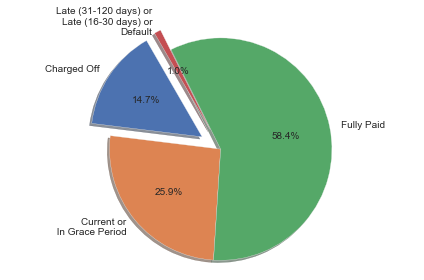

In [168]:
#pie chart of loan_status
labels = [ 'Charged Off','Current or\n In Grace Period', 'Fully Paid', 'Late (31-120 days) or\nLate (16-30 days) or\nDefault']
sizes = [259692,456653,1029307,17025]
explode = [0.2,0, 0 ,0.2]

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=120)

plt.axis('equal')
plt.tight_layout()
plt.savefig('./figure1.png')

In [151]:
# outcome label 'good_bad' was created.
pd.options.mode.chained_assignment = None 

df1['good_bad'] = np.where(df1['loan_status'].isin(['Charged Off', 'Default','Late (31-120 days)','Late (16-30 days)' ]), 1, 0) 
df1['good_bad'].value_counts()/df1['good_bad'].value_counts().sum()

0    0.843016
1    0.156984
Name: good_bad, dtype: float64

In [130]:
# table for bad_rate broken down by year

def bad_rate_by_cat(df, groupvar, dependcar):
    bad = df.groupby(groupvar)[dependcar].sum()
    count = df.groupby(groupvar)[dependcar].count()
    rate = df.groupby(groupvar)[dependcar].sum()/df.groupby(groupvar)[dependcar].count()
    bad_rate_by_cat = pd.concat((bad, count,rate), axis =1)
    bad_rate_by_cat.columns =  ['bad', 'total_count', 'bad_rate'] 
    
    return bad_rate_by_cat

bad_rate_by_cat(df1, 'issue_y', 'good_bad')

,bad,total_count,bad_rate
issue_y,,,
2007,45,251,0.179283
2008,247,1562,0.158131
2009,594,4716,0.125954
2010,1487,11536,0.128901
2011,3297,21721,0.151789
2012,8644,53367,0.161973
2013,21027,134814,0.155970
2014,41569,235629,0.176417
2015,77442,421095,0.183906


In [131]:
# percentage of missing values for each feature
pd.options.display.max_rows = None 

null_var =( df1.isnull().sum()/len(df1)).round(4).sort_values(ascending=False)
null_var[null_var > 0]

member_id                                     1.0000
orig_projected_additional_accrued_interest    0.9953
hardship_amount                               0.9940
hardship_type                                 0.9940
hardship_reason                               0.9940
hardship_status                               0.9940
deferral_term                                 0.9940
hardship_start_date                           0.9940
hardship_end_date                             0.9940
payment_plan_start_date                       0.9940
hardship_dpd                                  0.9940
hardship_loan_status                          0.9940
hardship_length                               0.9940
hardship_payoff_balance_amount                0.9940
hardship_last_payment_amount                  0.9940
sec_app_mths_since_last_major_derog           0.9923
settlement_date                               0.9808
settlement_term                               0.9808
settlement_percentage                         

In [132]:
# features with more than 50% missing values
feature_del_lst = (null_var[null_var > 0.5]).index.to_list()
len(feature_del_lst)

45

In [133]:
# delete features with more than 50% missing values
df1.drop(feature_del_lst, axis=1 , inplace = True)

In [135]:
df1.shape

(1762710, 108)

In [137]:
# The below columns were identified as features available after the borrowers' loans defaulted.
# our goal is using features of loans application and behavior of active loans to predict the loan default, so they are removed from the analysis. 
 
remove_lst = ['loan_status',
 'num_tl_120dpd_2m',
 'collection_recovery_fee',
 'last_pymnt_d',
 'collections_12_mths_ex_med',
 'delinq_amnt',
 'emp_title',
 'recoveries',
 'hardship_flag',
 'title',
 'chargeoff_within_12_mths',
 'num_tl_30dpd',
 'acc_now_delinq',
 'num_tl_90g_dpd_24m',
 'issue_y',
 'debt_settlement_flag',
 'tot_coll_amt']

df1.drop(remove_lst, axis=1 , inplace = True)
df1.shape

(1762710, 91)

In [140]:
df1.isnull().sum().sort_values(ascending = False)

mths_since_last_delinq        880684
all_util                      863503
open_acc_6m                   863414
inq_last_12m                  863414
total_cu_tl                   863414
open_rv_12m                   863413
inq_fi                        863413
open_rv_24m                   863413
max_bal_bc                    863413
total_bal_il                  863413
open_il_24m                   863413
open_il_12m                   863413
open_act_il                   863413
mths_since_recent_inq         231414
mo_sin_old_il_acct            117945
emp_length                    104919
pct_tl_nvr_dlq                 67713
avg_cur_bal                    67590
num_rev_accts                  67561
mo_sin_old_rev_tl_op           67561
mo_sin_rcnt_rev_tl_op          67561
mo_sin_rcnt_tl                 67560
total_rev_hi_lim               67560
tot_cur_bal                    67560
num_il_tl                      67560
num_tl_op_past_12m             67560
num_accts_ever_120_pd          67560
n

Noticed that there are 38 columns having same number of missing values of 33. Looks like those were summary rows that were present in original lendingclub csv files. Those rows were removed from the analysis.

In [143]:
# rows with missing values in loan_amnt,funded_amnt, total_acc....
df_missing = df1.loc[:,:][df1['pub_rec'].isnull()]
df_missing

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,policy_code,application_type,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,good_bad
421095,Total amount funded in policy code 1: 6417608175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
421096,Total amount funded in policy code 2: 1944088810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
528961,Total amount funded in policy code 1: 1741781700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
528962,Total amount funded in policy code 2: 564202131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
651664,Total amount funded in policy code 1: 1791201400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
651665,Total amount funded in policy code 2: 651669342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
749520,Total amount funded in policy code 1: 1443412975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [144]:
df_missing.shape

(33, 91)

In [145]:
# remove rows with missing values in loan_amnt, funded_amnt,....
mask = df1['pub_rec'].isnull()
df1.shape
df2 = df1[~mask]
df2.shape

(1762677, 91)

In [174]:
# Below columns still contains over 800000 missing values which are more than 40% of entire data. The columns were removed from the analysis.
null_var1 = df2.isnull().sum()
feature_del_lst1 = (null_var1[null_var1 > 800000]).index.to_list()
len(feature_del_lst1)
feature_del_lst1

df2.drop(feature_del_lst1, axis=1 , inplace = True)
df2.shape

(1762677, 78)

In [182]:
df2['good_bad'].value_counts()/df2['good_bad'].value_counts().sum()

0    0.843013
1    0.156987
Name: good_bad, dtype: float64

In [188]:
null_var2 = df2.isnull().sum().sort_values(ascending = False)
null_var2[null_var2 > 0]

#df2.loc[:, :][df2['num_bc_tl'].isnull()].head(2000)

mths_since_recent_inq         231381
mo_sin_old_il_acct            117912
emp_length                    104886
pct_tl_nvr_dlq                 67680
avg_cur_bal                    67557
mo_sin_old_rev_tl_op           67528
mo_sin_rcnt_rev_tl_op          67528
num_rev_accts                  67528
num_bc_tl                      67527
num_il_tl                      67527
mo_sin_rcnt_tl                 67527
num_accts_ever_120_pd          67527
num_actv_bc_tl                 67527
num_actv_rev_tl                67527
tot_cur_bal                    67527
total_rev_hi_lim               67527
num_op_rev_tl                  67527
tot_hi_cred_lim                67527
num_rev_tl_bal_gt_0            67527
total_il_high_credit_limit     67527
num_tl_op_past_12m             67527
bc_util                        66519
percent_bc_gt_75               66034
bc_open_to_buy                 65598
mths_since_recent_bc           64465
num_bc_sats                    55841
num_sats                       55841
m

In [191]:
#delete rows 
mask = df2['num_bc_tl'].isnull()
mask.head()
df3=df2[~mask]
df3.shape

(1695150, 78)

In [192]:
df3['good_bad'].value_counts()/df3['good_bad'].value_counts().sum()

0    0.842846
1    0.157154
Name: good_bad, dtype: float64

In [201]:
null_var3 = df3.isnull().sum().sort_values(ascending = False)
null_var3[null_var3 > 0]

#sns.boxplot(x = 'good_bad', y = 'mths_since_recent_inq', data = df3)

mths_since_recent_inq    181439
emp_length               102859
mo_sin_old_il_acct        50385
bc_util                   18954
percent_bc_gt_75          18482
bc_open_to_buy            18046
mths_since_recent_bc      16945
revol_util                 1089
dti                         579
pct_tl_nvr_dlq              153
last_credit_pull_d           63
avg_cur_bal                  30
zip_code                      1
num_rev_accts                 1
mo_sin_old_rev_tl_op          1
inq_last_6mths                1
mo_sin_rcnt_rev_tl_op         1
dtype: int64